# _Set Up and Data Processing_ 

(Friday June 28, 2019)

In [1]:
from capstone import data
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [4]:
# take 5% of data with seed of 8 and a single pathology, Atelectasis
train_df, valid_df = data.data_processing(path, 'Cardiomegaly', 8, 0.05);

(223414, 19)
(234, 19)
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed.
------------------------------
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Training shape
(11071, 2)

Validation shape
(234, 2)


In [5]:
train_df.head(10)

,Path,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00006/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00031/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00031/study3/...,0.0
3,CheXpert-v1.0-small/train/patient00031/study2/...,0.0
4,CheXpert-v1.0-small/train/patient00044/study7/...,1.0
5,CheXpert-v1.0-small/train/patient00044/study7/...,1.0
6,CheXpert-v1.0-small/train/patient00044/study6/...,1.0
7,CheXpert-v1.0-small/train/patient00044/study6/...,1.0
8,CheXpert-v1.0-small/train/patient00044/study5/...,0.0
9,CheXpert-v1.0-small/train/patient00044/study2/...,0.0


In [7]:
train_df['Cardiomegaly'].value_counts()

 0.0    9320
 1.0    1344
-1.0     407
Name: Cardiomegaly, dtype: int64

In [8]:
valid_df.head()

,Path,Cardiomegaly
0,CheXpert-v1.0-small/valid/patient64541/study1/...,1.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


# _U-Zero: Convert Uncertain (-1) Labels to Negative (0) Labels_

In [10]:
train_df = train_df[train_df['Cardiomegaly'] != -1].reset_index(drop=True)
train_df['Cardiomegaly'] = train_df['Cardiomegaly'].astype(int)
valid_df['Cardiomegaly'] = valid_df['Cardiomegaly'].astype(int)

In [11]:
train_df.head(15)

,Path,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00006/study1/...,0
1,CheXpert-v1.0-small/train/patient00031/study1/...,0
2,CheXpert-v1.0-small/train/patient00031/study3/...,0
3,CheXpert-v1.0-small/train/patient00031/study2/...,0
4,CheXpert-v1.0-small/train/patient00044/study7/...,1
5,CheXpert-v1.0-small/train/patient00044/study7/...,1
6,CheXpert-v1.0-small/train/patient00044/study6/...,1
7,CheXpert-v1.0-small/train/patient00044/study6/...,1
8,CheXpert-v1.0-small/train/patient00044/study5/...,0
9,CheXpert-v1.0-small/train/patient00044/study2/...,0


In [12]:
valid_df.head()

,Path,Cardiomegaly
0,CheXpert-v1.0-small/valid/patient64541/study1/...,1
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0


In [13]:
train_df.shape

(10664, 2)

# _U-Ones: Relabel Uncertain (-1) Labels as Positive Labels (1)_

In [8]:
#train_df = train_df.replace(-1, 1)
#train_df['Atelectasis'] = train_df['Atelectasis'].astype(int)
#train_df['Atelectasis'].value_counts()

In [11]:
#33739 + 33376

67115

# _Set Up for DL Training_

In [14]:
# default transformations
tfms = get_transforms()

In [15]:
src = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [16]:
src = src.split_by_rand_pct(0.2)

In [17]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 7601MB of GPU RAM free


In [18]:
data = (src.label_from_df(cols='Cardiomegaly')
        .transform(tfms, size=64)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

data.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [19]:
print(data.c)
print(data.classes)

2
[0, 1]


In [20]:
data

ImageDataBunch;

Train: LabelList (8532 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (2132 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
1,0,0,1,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /home/jupyter/springboard-capstone-2/data

In [21]:
# create a pretrained resnet152 cnn_learner with error rate and AUROC as the metrics with a ps of 0.5 (i.e. 50% of randomly selected neurons will be ignored from the n-1 layer) and batch normalization
learn = cnn_learner(data=data, base_arch=models.resnet152, metrics=[error_rate, AUROC()], pretrained=True,
                     ps=0.5, bn_final=True)

In [23]:
# load weights from previous best performing model
#learn.load('trial14-rd3-atelectasis-fulldata');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.88E+01
Min loss divided by 10: 1.58E-01


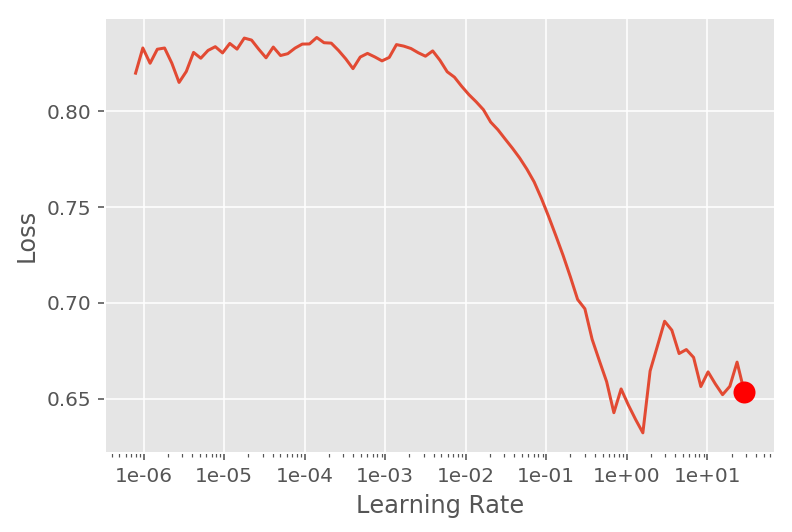

In [22]:
learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [23]:
lr = 1e-1
lr

0.1

In [24]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

# _Rd. 1 Training_

In [25]:
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.383792,0.385042,0.127111,0.514343,01:28
1,0.379749,0.405372,0.127580,0.510867,01:29
2,0.375020,0.378614,0.127111,0.548929,01:28
3,0.407118,3.359595,0.143527,0.559343,01:30
4,0.377540,21.387630,0.143527,0.590243,01:29


In [26]:
learn.save('trial16-rd1')

# _Rd. 2 Training_

In [27]:
# load weights
learn.load('trial16-rd1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-07
Min loss divided by 10: 2.24E-07


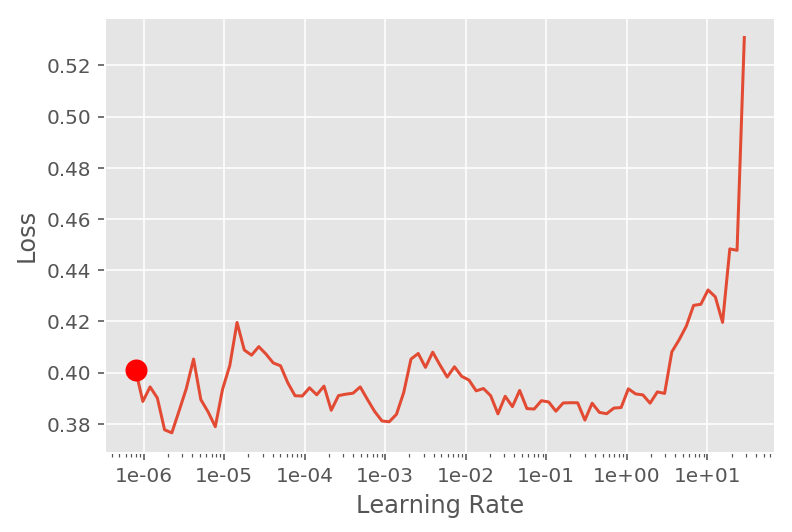

In [28]:
# unfreeze all layers
learn.unfreeze()

learn.lr_find(start_lr=1e-7, end_lr=100)
learn.recorder.plot(suggestion=True)

In [31]:
lr = 7e-4

In [32]:
# train model
learn.fit_one_cycle(5, slice(lr), callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.363510,0.384067,0.127111,0.524757,02:00
1,0.372810,0.372268,0.127111,0.637300,01:59
2,0.378019,0.361221,0.127111,0.709903,02:00
3,0.349902,0.348501,0.127111,0.730657,01:59
4,0.353787,0.347659,0.127111,0.742448,02:00


In [51]:
learn.save('trial15-rd2')

# _Full Data Set_

In [53]:
from capstone import data
# take 100% of data with seed of 8 and a single pathology, Atelectasis
train_df, valid_df = data.data_processing(path, 'Cardiomegaly', 8, 1);

(223414, 19)
(234, 19)
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed.
------------------------------
Created training and validation dataframe with expressed competition task, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Training shape
(223414, 2)

Validation shape
(234, 2)


In [54]:
train_df = train_df[train_df['Cardiomegaly'] != -1].reset_index(drop=True)
train_df['Cardiomegaly'] = train_df['Cardiomegaly'].astype(int)
valid_df['Cardiomegaly'] = valid_df['Cardiomegaly'].astype(int)

In [55]:
src2 = (ImageList.from_df(df=train_df, path=path, folder='.', suffix=''))

In [56]:
src2 = src.split_by_rand_pct(0.2)

In [57]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: 
    bs=32
else:           
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 6770MB of GPU RAM free


In [58]:
data2 = (src2.label_from_df(cols='Cardiomegaly')
        .transform(tfms, size=64)
        .databunch(bs = bs)
        .normalize(imagenet_stats))
# add test set
data2.add_test(ImageList.from_df(valid_df, path=path, folder='.', suffix=''))

In [59]:
print(data2.c)
print(data2.classes)

2
[0, 1]


In [60]:
learn.data = data2

In [61]:
data2

ImageDataBunch;

Train: LabelList (172262 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (43065 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /home/jupyter/springboard-capstone-2/data

# _Train on Full Data Set_

In [63]:
learn.load('trial15-rd2');

In [64]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-07
Min loss divided by 10: 2.00E-08


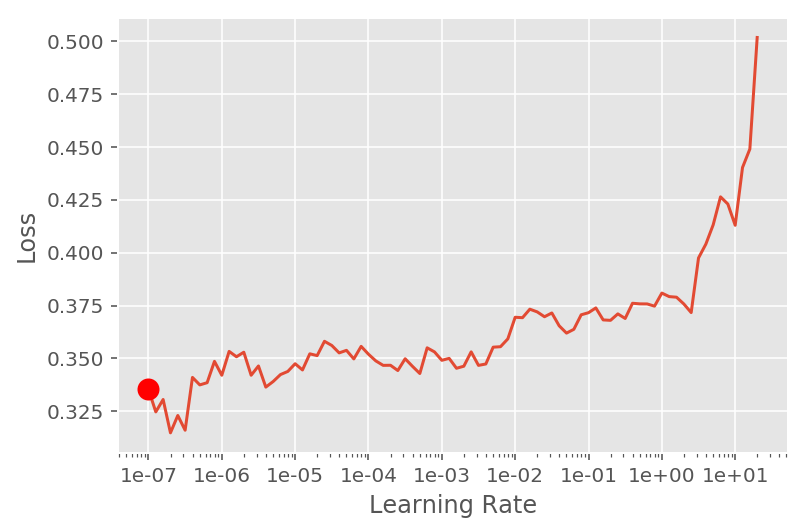

In [65]:
learn.lr_find(start_lr=1e-8, end_lr=100)
learn.recorder.plot(suggestion=True)

In [67]:
lr = 1e-7

In [68]:
learn.fit_one_cycle(3, slice(lr), callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=1)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.341609,0.363187,0.129316,0.720747,30:20
1,0.343073,0.366476,0.129316,0.722164,30:33


Epoch 2: early stopping


In [69]:
learn.save('trial16-rd3')